# About Dataset
This is the classification based E-commerce text dataset for 4 categories - "Electronics", "Household", "Books" and "Clothing & Accessories", which almost cover 80% of any E-commerce website.

The dataset is in ".csv" format with two columns - the first column is the class name and the second one is the datapoint of that class. The data point is the product and description from the e-commerce website.

The dataset has the following features :

Data Set Characteristics: Multivariate

Number of Instances: 50425

Number of classes: 4

Area: Computer science

Attribute Characteristics: Real

Number of Attributes: 1

Associated Tasks: Classification

Missing Values? No

Gautam. (2019). E commerce text dataset (version - 2) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.3355823

# Import Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Bidirectional
from keras.layers import Dense, Dropout, GlobalMaxPool1D
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import warnings
warnings.filterwarnings("ignore")

# Load the Data

In [4]:
df = pd.read_csv("data/ecommerceDataset.csv", names=["label", "text"])

In [5]:
df.head()

,label,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


# Check of Data

In [6]:
print("Number of Columns: ", df.shape[1])
print("Number of Rows: ", df.shape[0])

Number of Columns:  2
Number of Rows:  50425


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50425 non-null  object
 1   text    50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [8]:
df.isnull().sum()

label    0
text     1
dtype: int64

In [9]:
print("Number of Duplicates: ", df.duplicated().sum())

Number of Duplicates:  22622


In [10]:
df["label"].value_counts()

label
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64

# Exploratory Data Anlaysis (EDA)

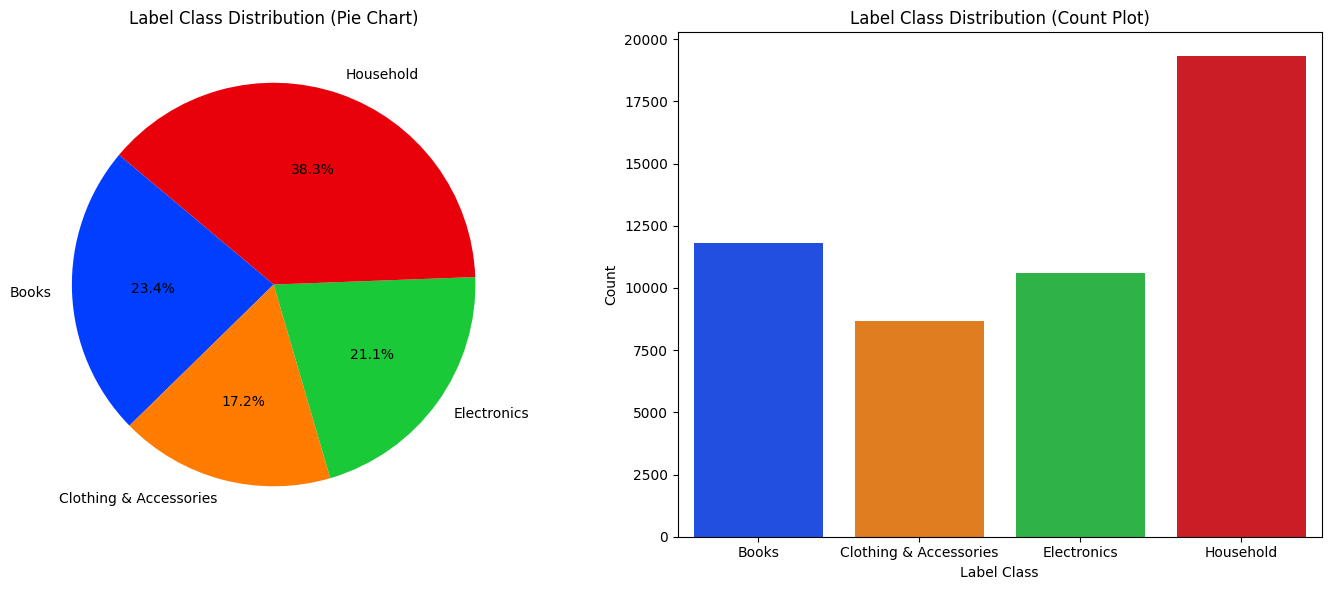

In [9]:
class_counts = df["label"].value_counts().sort_index()

palette = sns.color_palette("bright", n_colors=len(class_counts))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=palette)
ax1.set_title('Label Class Distribution (Pie Chart)')
sns.countplot(x="label", data=df, ax=ax2, order=class_counts.index, palette=palette)
ax2.set_title('Label Class Distribution (Count Plot)')
ax2.set_xlabel('Label Class')
ax2.set_ylabel('Count')
plt.tight_layout()
plt.show()

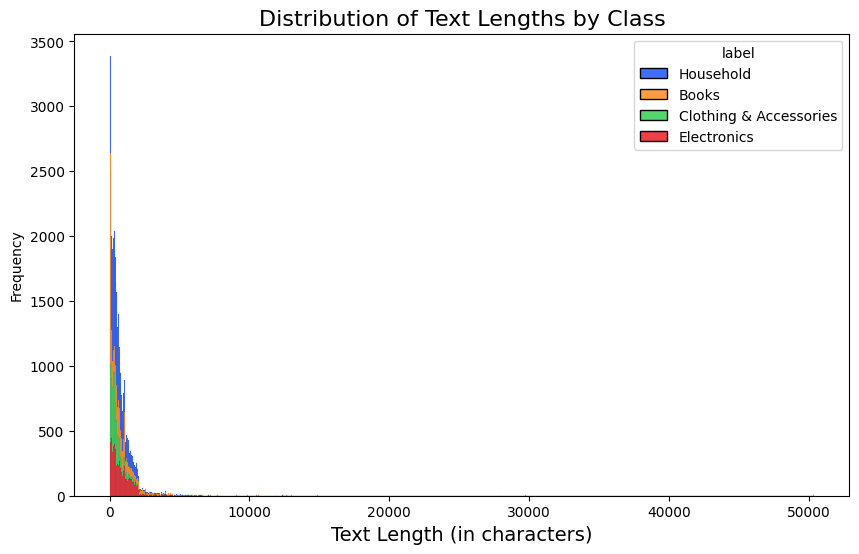

In [10]:
df["word_length"] = df["text"].fillna("").apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="word_length", hue="label", multiple="stack", palette="bright")
plt.title('Distribution of Text Lengths by Class', fontsize=16)
plt.xlabel('Text Length (in characters)', fontsize=14)
plt.ylabel('Frequency')
plt.show()

In [11]:
from nltk.corpus import stopwords
from PIL import Image

def MaskCloud(Text,ImagePath,Width): 
    ThisMask = np.array(Image.open(ImagePath))
    ThisMask = ThisMask[:,:,0]
    def transform_format(val):
        if val == 0:
            return 255
        else:
            return val
    TransformedThisMask = np.ndarray((ThisMask.shape[0],ThisMask.shape[1]), np.int32)
    for i in range(len(ThisMask)):
        TransformedThisMask[i] = list(map(transform_format, ThisMask[i]))
    wc = WordCloud(background_color="white", max_words=1000, mask=TransformedThisMask,
                    contour_width=Width, contour_color='black')
    wc.generate(Text)
    plt.figure(figsize=[20,10])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return None

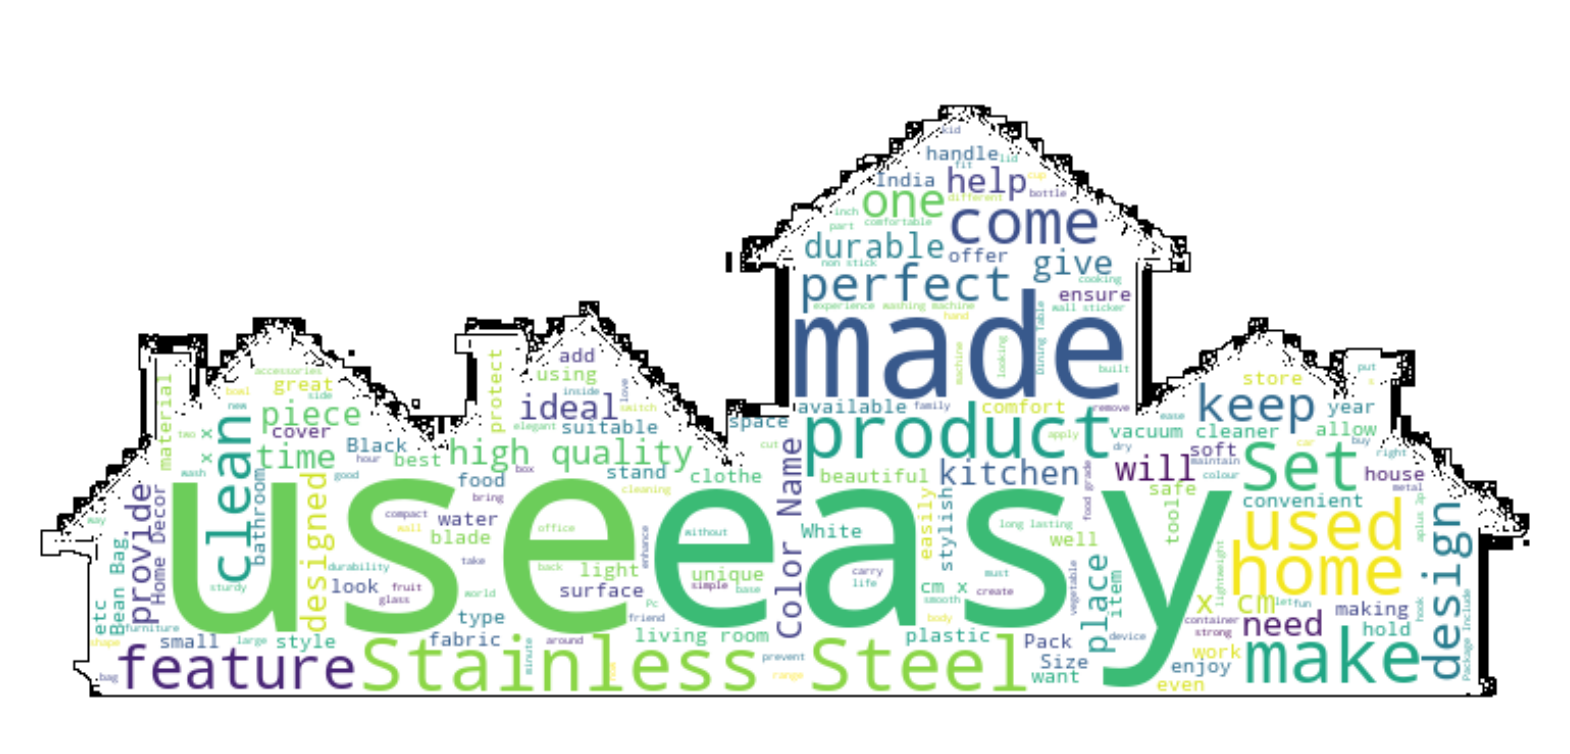

In [12]:
MaskCloud(" ".join(df[df["label"] == "Household"]["text"]), 
          "images/house.jpg",
          1)

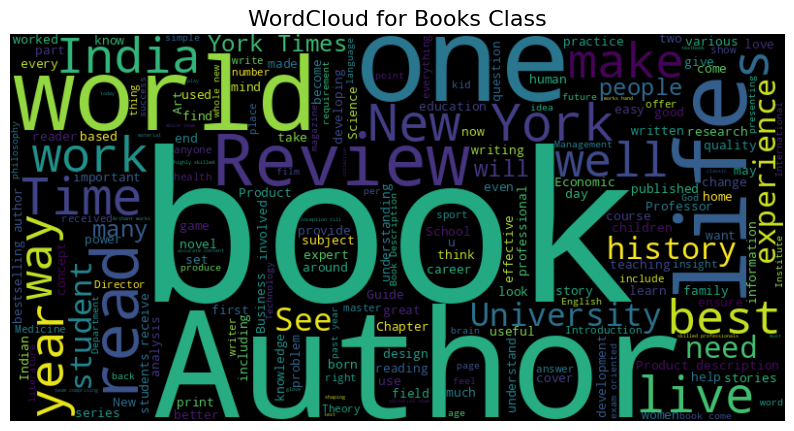

In [13]:
books_text = ' '.join(df[df['label'] == 'Books']['text'])
books_text_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='viridis').generate(books_text)

plt.figure(figsize=(10, 6))
plt.imshow(books_text_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Books Class', fontsize=16)
plt.show()

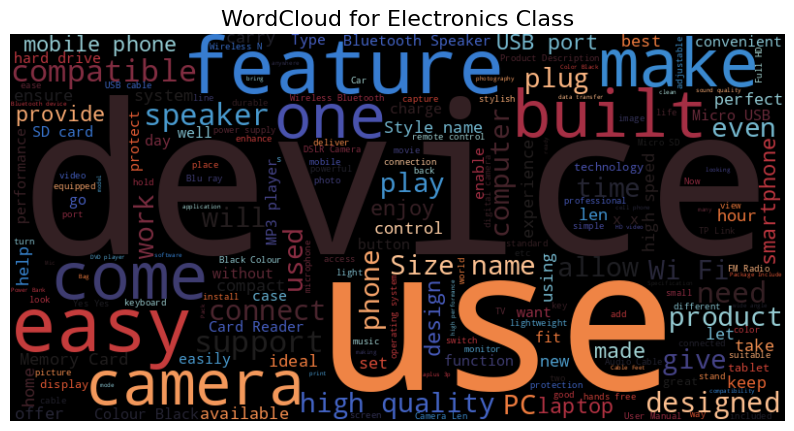

In [14]:
electronics_text = ' '.join(df[df['label'] == 'Electronics']['text'])
electronics_text_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='icefire').generate(electronics_text)

plt.figure(figsize=(10, 6))
plt.imshow(electronics_text_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Electronics Class', fontsize=16)
plt.show()

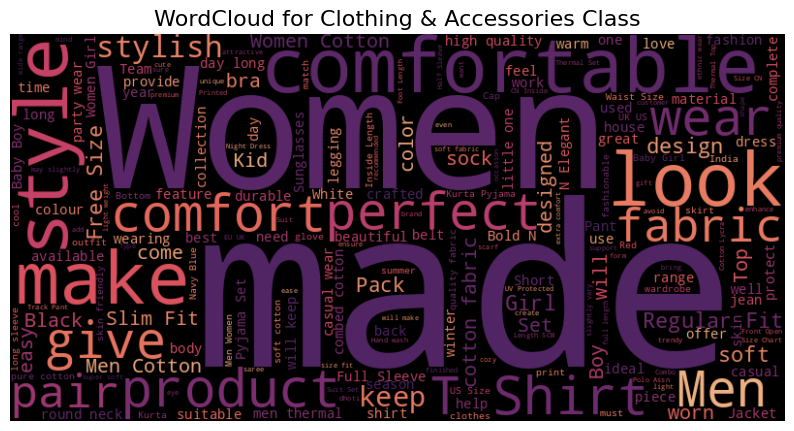

In [15]:
clothing_text = ' '.join(df[df['label'] == 'Clothing & Accessories']['text'].fillna(""))
clothing_text_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='flare').generate(clothing_text)

plt.figure(figsize=(10, 6))
plt.imshow(clothing_text_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Clothing & Accessories Class', fontsize=16)
plt.show()

# Missing Values and Garbage Treatment

In [14]:
df.dropna(inplace=True)

In [15]:
df.drop_duplicates(inplace=True)

# Text Preprocessing

In [16]:
X = df["text"]
y = df["label"]

In [19]:
nlp = spacy.load("en_core_web_sm")

def text_cleaning(text):
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', ' ', text)
    
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    doc = nlp(text)
    
    cleaned_tokens = []
    for token in doc:
        if token.text not in STOP_WORDS and not token.is_punct and not token.is_space:
            cleaned_tokens.append(token.lemma_)
    
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

X = X.apply(text_cleaning)

In [20]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [21]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)

seq = tokenizer.texts_to_sequences(X)

In [22]:
X = pad_sequences(seq, maxlen=100, padding='post')

In [23]:
y = to_categorical(y, num_classes=4)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16681, 100), (11121, 100), (16681, 4), (11121, 4))

In [25]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_test.shape, X_val.shape, y_test.shape, y_val.shape

((5560, 100), (5561, 100), (5560, 4), (5561, 4))

# Model Building

In [26]:
vocab_size = len(tokenizer.word_counts)
emb_dim = 128
input_length = 100
num_classes = 4

In [27]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=input_length))
model.add(Bidirectional(LSTM(128, activation="tanh", return_sequences=True)))
model.add(Dropout(0.5))
model.add(GlobalMaxPool1D())
model.add(Dense(256, activation="tanh"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="tanh"))
model.add(Dense(4, activation="softmax"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(loss=CategoricalCrossentropy(), 
              optimizer=Adam(), 
              metrics=["accuracy"])

In [29]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

model.fit(X_train, y_train, batch_size=128, epochs=20, 
          validation_data=(X_val, y_val), 
          callbacks=[early_stopping])

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 471ms/step - accuracy: 0.6745 - loss: 0.7709 - val_accuracy: 0.9426 - val_loss: 0.2608
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 62s 473ms/step - accuracy: 0.9655 - loss: 0.1310 - val_accuracy: 0.9448 - val_loss: 0.2104
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 62s 472ms/step - accuracy: 0.9848 - loss: 0.0561 - val_accuracy: 0.9444 - val_loss: 0.1916
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 468ms/step - accuracy: 0.9923 - loss: 0.0278 - val_accuracy: 0.9430 - val_loss: 0.1985
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 470ms/step - accuracy: 0.9941 - loss: 0.0230 - val_accuracy: 0.9403 - val_loss: 0.2245
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 469ms/step - accuracy: 0.9958 - loss: 0.0145 - val_accuracy: 0.9430 - val_loss: 0.2341
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 466ms/step - accuracy: 0.9972 - loss: 0.0092 - val_accuracy: 0.9419 - val_loss: 0.2414
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 460ms/step - accuracy: 0.9983 - loss: 0

# Evaluation

In [30]:
model.evaluate(X_test, y_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9525 - loss: 0.1674


[0.1843016892671585, 0.9471222758293152]

In [31]:
y_true = []

for i in range(len(y_test)):
    
    x = np.argmax(y_test[i])
    y_true.append(x)

In [32]:
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)

174/174 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step


In [33]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1262
           1       0.98      0.96      0.97      1126
           2       0.91      0.92      0.92      1047
           3       0.95      0.95      0.95      2125

    accuracy                           0.95      5560
   macro avg       0.95      0.95      0.95      5560
weighted avg       0.95      0.95      0.95      5560



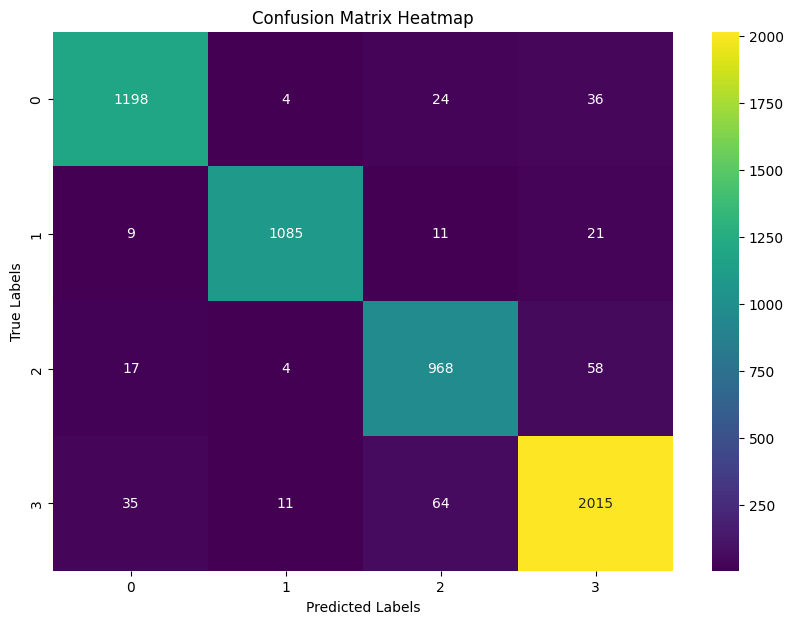

In [34]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()